In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split
from scipy.io import savemat, loadmat
import pylab as plt
import numpy as np
from scipy.spatial.distance import cdist
from IPython.display import clear_output
import ipywidgets as ipw
import scipy.ndimage as ndimage
from scipy.interpolate import RegularGridInterpolator
import timeit
import pandas as pd
from tqdm import tqdm_notebook
from keras.layers import *

Using TensorFlow backend.


In [3]:
import sys
sys.path.append('../../')
import src.approximation as appr
import src.plot_utils as plot_utils
import src.ml_utils as ml_utils

In [4]:
def data_input_layered(path='../../data/'):
    data = loadmat(path + 'layered_traveltimes.mat')
    vp = loadmat(path + 'layered_model.mat')['vp'].T
    time = data['time']
    sou = np.stack([np.float32(data['SX']), np.float32(data['SZ'])], axis=-1)
    rec = np.stack([np.float32(data['SX'][:,0]), np.float32(data['SX'][0,:])]).T
    return sou, rec, time, vp

def data_input_seg(path='../../data/'):
    data = loadmat(path + 'seg_traveltimes.mat')
    vp = loadmat(path + 'seg_model.mat')['Vp'].T
    time = data['time']
    sou = np.stack([np.float32(data['SX']), np.float32(data['SZ'])], axis=-1)
    rec = np.stack([np.float32(data['SX'][:,0]), np.float32(data['SX'][0,:])]).T
    return sou, rec, time, vp

def init_interpolation(sou, rec, time):
    x = rec[:,0]
    y = sou[0,:,1]
    z = sou[:,0,0]
    assert len(time.shape) > 2 and time.shape[0] == rec.shape[0]
    
    return RegularGridInterpolator((x, y, z), time, method='linear', 
                                    bounds_error=False, fill_value=None)

## Import of data sets

In [5]:
sou, rec, time, vp = data_input_layered()

sou_x = sou[:,0,0]
sou_z = sou[0,:,1]
rec_x = rec[:, 0]
output = time[..., None]

input_scaler = ml_utils.Scaler(sou_x)
sou_x_sc = input_scaler.scale(sou_x, verbose=True)
sou_z_sc = input_scaler.scale(sou_z)
rec_x_sc = input_scaler.scale(rec_x)

Before scaling:
Mean: 1000.0	Std: 580.22998046875
After scaling:
Mean: 0.0	Std: 1.0


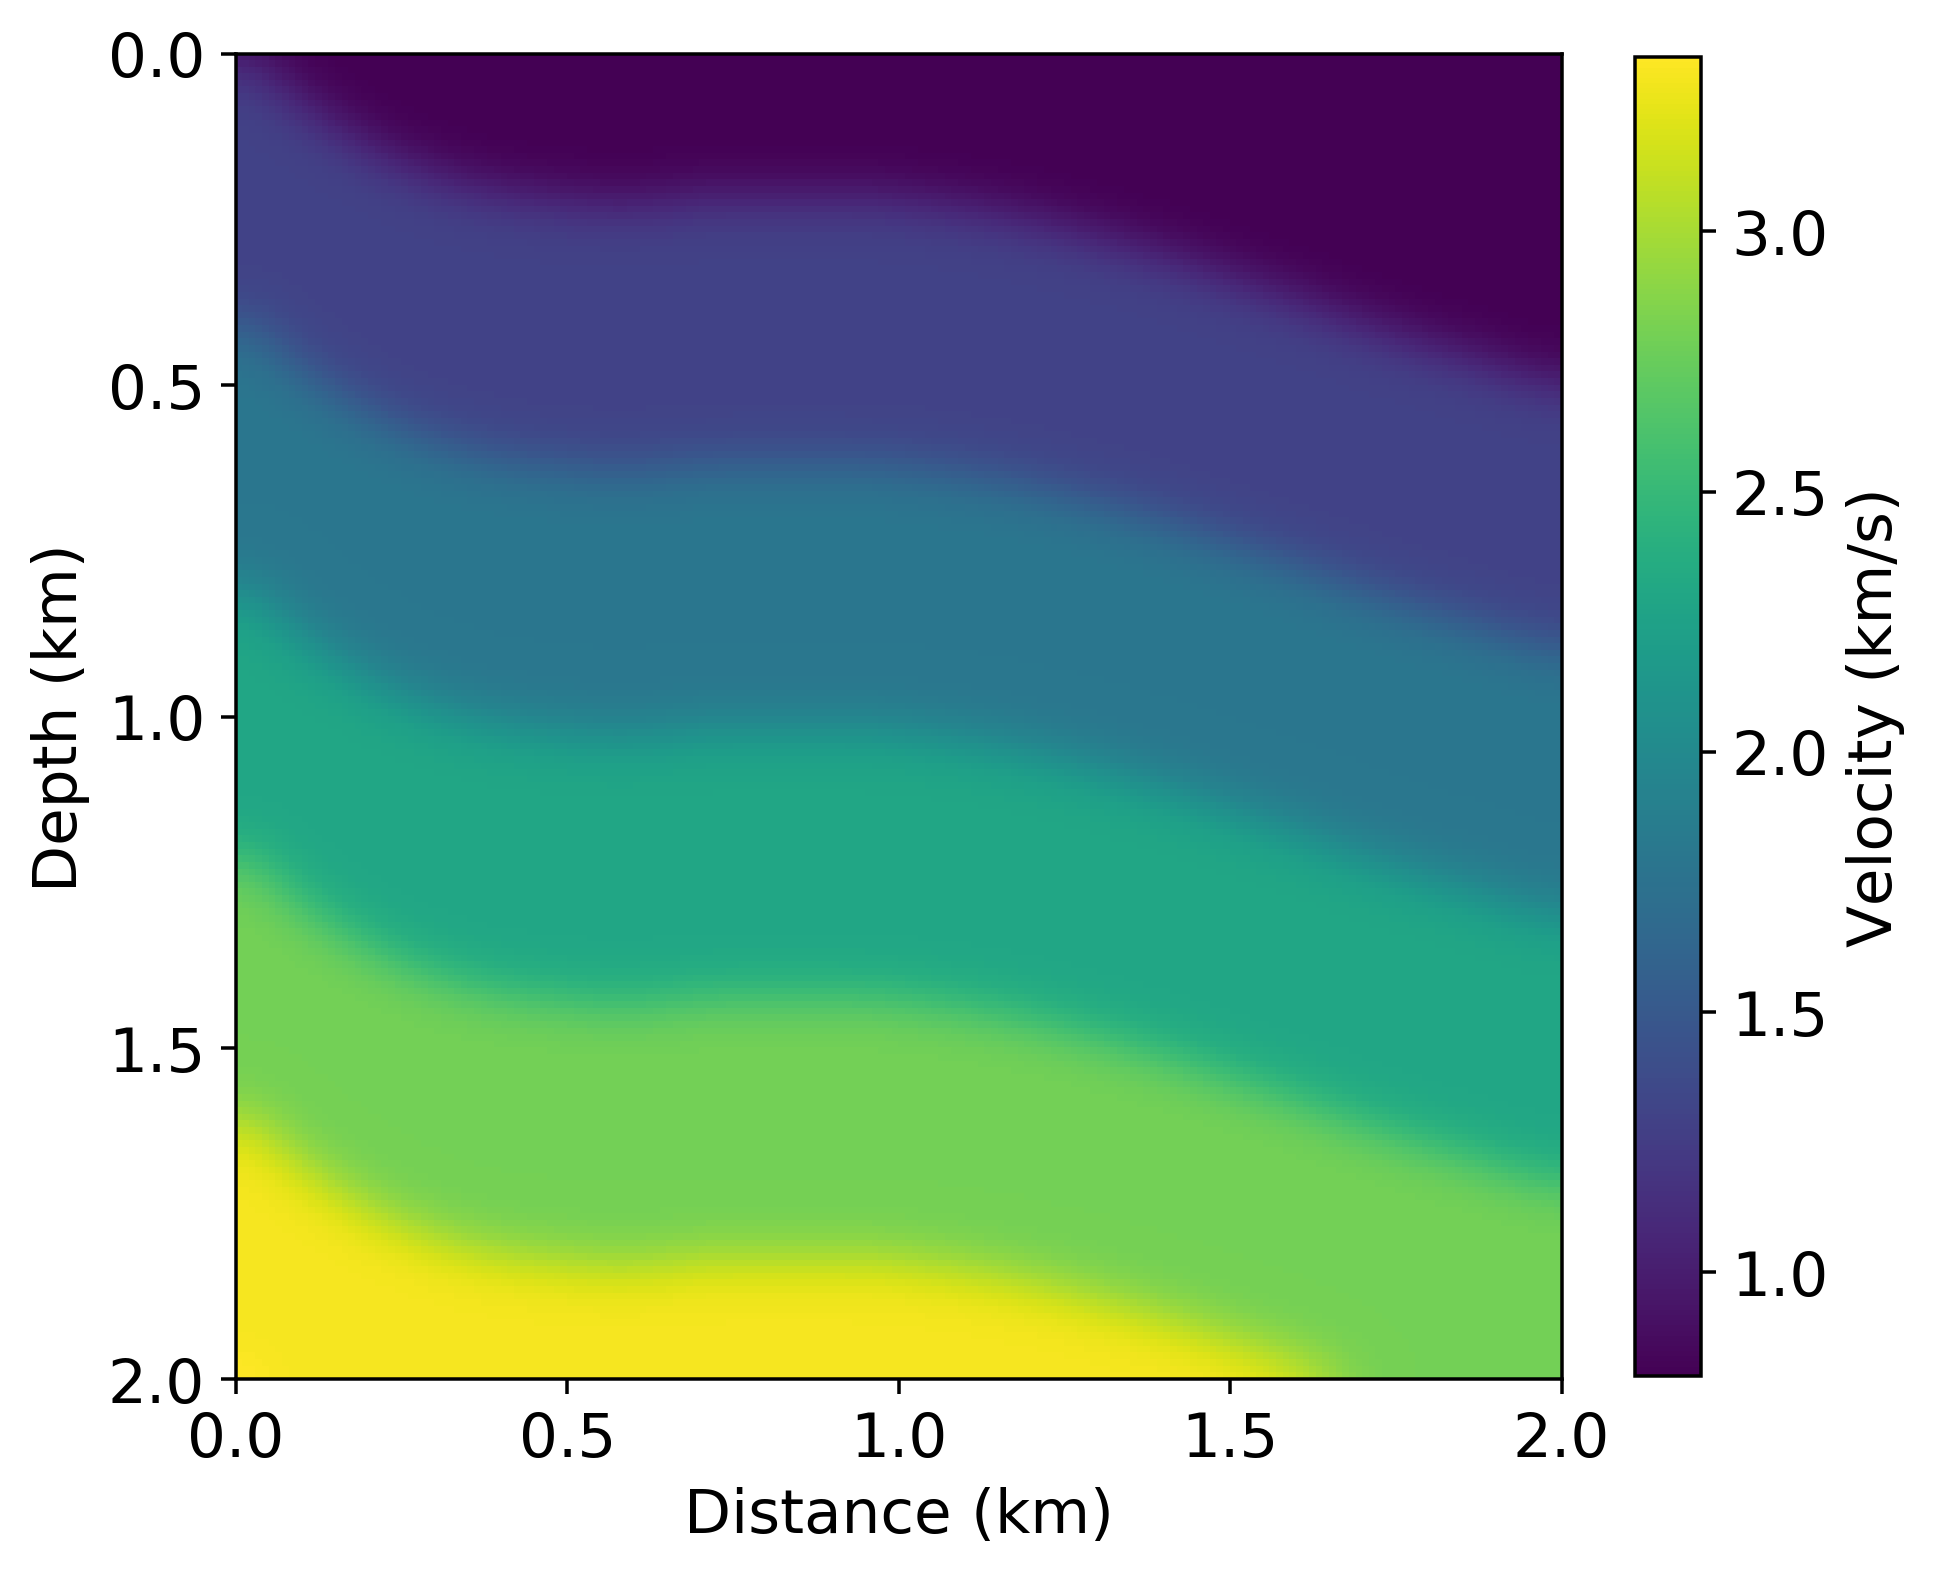

In [6]:
fs = 14

fig = plt.figure(figsize=(6,6), dpi=315)
ax = fig.add_subplot(111)
im = ax.pcolormesh(sou_x / 1000, sou_z / 1000, vp / 1000)
ax.set_xlabel('Distance (km)', fontsize=fs)
ax.set_ylabel('Depth (km)', fontsize=fs)
ax.tick_params(labelsize=fs)
ax.set_yticks(np.linspace(2, 0, 5))
ax.set_ylim([2.0, 0.0])
cbar = plt.colorbar(mappable=im, ax=ax, fraction=1/22.2)
cbar.set_label(label='Velocity (km/s)', fontsize=fs)
cbar.ax.tick_params(labelsize=fs)
ax.axis('scaled')
plt.show()

In [6]:
train_set = appr.Approximator.prepare_inputs(inputs=[rec_x_sc, sou_x_sc, sou_z_sc], outputs=output, 
                                                        flatenned=False, sparse=[1,10,10])
test_set = appr.Approximator.prepare_inputs(inputs=[rec_x_sc, sou_x_sc, sou_z_sc], outputs=output, 
                                                        flatenned=False, sparse=[1,1,1])

In [15]:
optimizers.Adam()

'2.1.6'

## Creating early_stopping callback for all test NN models

In [14]:
from keras import optimizers
import keras

early = keras.callbacks.EarlyStopping(monitor='mae', min_delta=1e-8, patience=4, verbose=2, 
                                        mode='auto', restore_best_weights=False)
reducer = keras.callbacks.ReduceLROnPlateau(monitor='mae', factor=0.75, patience=3, verbose=1, 
                                            mode='auto', min_delta=1e-6, cooldown=0, min_lr=1e-7)

TypeError: __init__() got an unexpected keyword argument 'restore_best_weights'

## Testing number of layers and units

In [11]:
times, residuals, df = appr.Approximator.grid_search(train_set, test_number=5, max_epochs=100, callbacks=[early, reducer],
                                                layers=[1], units=[100, 250, 500, 1000, 1500, 2000, 2500, 3000], 
                                                lrates=[1e-3], decays=[1e-4])

df.to_excel('../../data/approximation/layer_1_new.xls')

MAX_EPOCHS:	100
TEST_NUMBER:	5
LAYERS:	[1]
UNITS:	[100, 250, 500, 1000, 1500, 2000, 2500, 3000]
ACTIVATION:	['relu']
BATCH_SIZE:	[100]
LRATE:	[0.001]
DECAY:	[0.0001]
LOSS:	['mse']
METRIC:	['mae']
TOTAL:	40


Train time: 200.34 sec
Predict time on train set: 1.92 sec
Train set: MAE = 5.814 ms, 0.804 %



Epoch 00071: ReduceLROnPlateau reducing learning rate to 0.0007500000356230885.

Epoch 00093: ReduceLROnPlateau reducing learning rate to 0.0005625000048894435.

Epoch 00099: ReduceLROnPlateau reducing learning rate to 0.0004218749818392098.
Train time: 192.92 sec
Predict time on train set: 2.09 sec
Train set: MAE = 5.648 ms, 0.811 %



Epoch 00059: ReduceLROnPlateau reducing learning rate to 0.0007500000356230885.

Epoch 00063: ReduceLROnPlateau reducing learning rate to 0.0005625000048894435.

Epoch 00071: ReduceLROnPlateau reducing learning rate to 0.0004218749818392098.

Epoch 00075: ReduceLROnPlateau reducing learning rate to 0.00031640623637940735.

Epoch 00082: ReduceLROnPlateau reducing learning rate to 0.00023730468819849193.

Epoch 00089: ReduceLROnPlateau reducing learning rate to 0.00017797851614886895.

Epoch 00096: ReduceLROnPlateau reducing learning rate to 0.0001334838816546

In [12]:
times, residuals, df = appr.Approximator.grid_search(train_set, test_number=5, max_epochs=80, callbacks=[early, reducer],
                                                layers=[2], units=[50, 75, 100, 150, 200, 300, 400, 500], 
                                                lrates=[1e-3], decays=[1e-4])

df.to_excel('../../data/approximation/layer_2_new.xls')

MAX_EPOCHS:	80
TEST_NUMBER:	5
LAYERS:	[2]
UNITS:	[50, 75, 100, 150, 200, 300, 400, 500]
ACTIVATION:	['relu']
BATCH_SIZE:	[100]
LRATE:	[0.001]
DECAY:	[0.0001]
LOSS:	['mse']
METRIC:	['mae']
TOTAL:	40


Train time: 165.64 sec
Predict time on train set: 2.05 sec
Train set: MAE = 3.655 ms, 0.448 %



Epoch 00063: ReduceLROnPlateau reducing learning rate to 0.0007500000356230885.

Epoch 00074: ReduceLROnPlateau reducing learning rate to 0.0005625000048894435.

Epoch 00079: ReduceLROnPlateau reducing learning rate to 0.0004218749818392098.
Train time: 164.14 sec
Predict time on train set: 1.96 sec
Train set: MAE = 4.261 ms, 0.568 %


Train time: 161.10 sec
Predict time on train set: 2.08 sec
Train set: MAE = 3.995 ms, 0.547 %


Train time: 168.05 sec
Predict time on train set: 2.24 sec
Train set: MAE = 3.840 ms, 0.520 %



Epoch 00073: ReduceLROnPlateau reducing learning rate to 0.0007500000356230885.

Epoch 00077: ReduceLROnPlateau reducing learning rate to 0.0005625000048894435.
Train time: 160.17 sec
Predict time on train set: 1.74 sec
Train set: MAE = 3.075 ms, 0.439 %



Epoch 00057: ReduceLROnPlateau reducing learning rate to 0.0007500000356230885.
Train time: 173.34 sec
Predict tim

In [13]:
times, residuals, df = appr.Approximator.grid_search(train_set, test_number=5, max_epochs=60, callbacks=[early, reducer],
                                                layers=[3], units=[50, 75, 100, 150, 200, 300, 400, 500],
                                                lrates=[1e-3], decays=[1e-4])

df.to_excel('../../data/approximation/layer_3_new.xls')

MAX_EPOCHS:	60
TEST_NUMBER:	5
LAYERS:	[3]
UNITS:	[50, 75, 100, 150, 200, 300, 400, 500]
ACTIVATION:	['relu']
BATCH_SIZE:	[100]
LRATE:	[0.001]
DECAY:	[0.0001]
LOSS:	['mse']
METRIC:	['mae']
TOTAL:	40



Epoch 00055: ReduceLROnPlateau reducing learning rate to 0.0007500000356230885.

Epoch 00060: ReduceLROnPlateau reducing learning rate to 0.0005625000048894435.
Train time: 132.43 sec
Predict time on train set: 2.09 sec
Train set: MAE = 3.148 ms, 0.423 %


Train time: 133.63 sec
Predict time on train set: 2.00 sec
Train set: MAE = 3.922 ms, 0.517 %


Train time: 137.33 sec
Predict time on train set: 2.16 sec
Train set: MAE = 3.498 ms, 0.449 %



Epoch 00058: ReduceLROnPlateau reducing learning rate to 0.0007500000356230885.
Train time: 130.26 sec
Predict time on train set: 1.87 sec
Train set: MAE = 4.118 ms, 0.531 %


Train time: 131.26 sec
Predict time on train set: 1.90 sec
Train set: MAE = 4.503 ms, 0.587 %



Epoch 00051: ReduceLROnPlateau reducing learning rate to 0.0007500000356230885.
Train time: 148.24 sec
Predict time on train set: 2.11 sec
Train set: MAE = 2.936 ms, 0.360 %



Epoch 00038: ReduceLROnPlateau reducing learning rate to 0.0007500000356230885.
Train time: 148.29 

In [19]:
df = pd.read_excel('../../data/approximation/layer_1_new.xls')
df = df.append(pd.read_excel('../../data/approximation/layer_2_new.xls'))
df = df.append(pd.read_excel('../../data/approximation/layer_3_new.xls'))
df = df.reset_index()
df = df.drop(axis=1, labels=['index', 'Unnamed: 0'])
df

,MAX_EPOCHS,TEST_NUMBER,LAYERS,UNITS,ACTIVATION,BATCH_SIZE,LRATE,DECAY,LOSS,METRIC,EPOCH_END,TRAIN_TIME,MAE_TEST
0,100,0,1,100,relu,100,0.001,0.0001,mse,mae,100,200.340356,0.005814
1,100,1,1,100,relu,100,0.001,0.0001,mse,mae,100,192.923655,0.005648
2,100,2,1,100,relu,100,0.001,0.0001,mse,mae,100,178.846310,0.005289
3,100,3,1,100,relu,100,0.001,0.0001,mse,mae,100,166.782822,0.005602
4,100,4,1,100,relu,100,0.001,0.0001,mse,mae,100,168.212254,0.004999
...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,60,0,3,500,relu,100,0.001,0.0001,mse,mae,60,494.637074,0.000673
116,60,1,3,500,relu,100,0.001,0.0001,mse,mae,60,466.913864,0.000610
117,60,2,3,500,relu,100,0.001,0.0001,mse,mae,60,484.548471,0.000485
118,60,3,3,500,relu,100,0.001,0.0001,mse,mae,60,486.697884,0.000515


In [20]:
min_indices = []
timemin_ind = []
df_group = df.groupby(['LAYERS', 'UNITS']).mean()
for i in range(1, 4):
    min_indices.append((i, df_group.loc[i].MAE_TEST.idxmin()))
    timemin_ind.append((i, df_group.loc[i].TRAIN_TIME.idxmin()))

In [21]:
df_group

MAX_EPOCHS  TEST_NUMBER  BATCH_SIZE  LRATE   DECAY  EPOCH_END  \
LAYERS UNITS                                                                  
1      100           100            2         100  0.001  0.0001        100   
       250           100            2         100  0.001  0.0001        100   
       500           100            2         100  0.001  0.0001        100   
       1000          100            2         100  0.001  0.0001        100   
       1500          100            2         100  0.001  0.0001        100   
       2000          100            2         100  0.001  0.0001        100   
       2500          100            2         100  0.001  0.0001        100   
       3000          100            2         100  0.001  0.0001        100   
2      50             80            2         100  0.001  0.0001         80   
       75             80            2         100  0.001  0.0001         80   
       100            80            2         100  0.001  0.0001         80   
       150            80            2         100  0.001  0.0001         80   
       200            80            2         100  0.001  0.0001         80   
       300            80            2         100  0.001  0.0001         80   
       400            80            2         100  0.001  0.0001         80   
       500            80            2         100  0.001  0.0001         80   
3      50             60            2         100  0.001  0.0001         60   
       75             60            2         100  0.001  0.0001         60   
       100            60            2         100  0.001  0.0001         60   
       150            60            2         100  0.001  0.0001         60   
       200            60            2         100  0.001  0.0001         60   
       300            60            2         100  0.001  0.0001         60   
       400            60            2         100  0.001  0.0001         60   
       500            60            2         100  0.001  0.0001         60   

              TRAIN_TIME  MAE_TEST  
LAYERS UNITS                        
1      100    181.421079  0.005470  
       250    177.422189  0.003461  
       500    196.759809  0.002271  
       1000   255.515885  0.001642  
       1500   287.230529  0.001283  
       2000   341.137802  0.001158  
       2500   382.647874  0.001100  
       3000   481.118110  0.001059  
2      50     163.819790  0.003765  
       75     175.033571  0.002615  
       100    190.284647  0.002478  
       150    214.788142  0.001443  
       200    231.389494  0.001221  
       300    247.339372  0.000779  
       400    283.988245  0.000610  
       500    392.744136  0.000631  
3      50     132.985405  0.003838  
       75     148.884097  0.002734  
       100    174.632522  0.001904  
       150    213.035019  0.001370  
       200    252.005958  0.001078  
       300    223.451049  0.000755  
       400    296.537719  0.000665  
       500    487.036597  0.000560

In [25]:
[250] * 1

[250]

In [36]:
nh = 3
nu = [50, 75, 100, 150, 200, 300, 400, 500]
for ni in nu:
    model = appr.Approximator(num_layers=nh, num_units=[ni]*nh, num_inputs=3, input_dim=1, output_dim=1)
    weights = np.array(model.nn_model.get_weights())
    size = 0.0
    for w in weights:
        size += w.nbytes
    print(ni, ' : ', size / 1024**1)

50  :  20.90234375
75  :  46.0
100  :  80.86328125
150  :  179.88671875
200  :  317.97265625
300  :  711.33203125
400  :  1260.94140625
500  :  1966.80078125


In [77]:
1 / 40 * 1000

25.0

In [1]:
1047 - 583

464

## According to the last test a test of learning rate is performed

In [ ]:
lrates = [1e-3, 5e-4, 1e-4, 5e-5, 1e-5]

In [ ]:
times, residuals, df = appr.Approximator.grid_search(train_set, test_number=5, max_epochs=100, callbacks=[early],
                                                layers=[1], units=[1500], 
                                                lrates=lrates, decays=[1e-4])

df.to_excel('../data/layer_1_lr.xls')

In [ ]:
df_lr = pd.read_excel('../data/layer_1_lr.xls')
df_lr = df_lr.append(pd.read_excel('../data/layer_2_lr.xls'))
df_lr = df_lr.append(pd.read_excel('../data/layer_3_lr.xls'))
df_lr = df_lr.reset_index()
df_lr = df_lr.drop(columns=['index', 'Unnamed: 0'])

In [ ]:
ind = []
df_lr_group = df_lr.groupby(['LAYERS','LRATE']).mean()
for i in [1,2,3]:
    ind.append((i, df_lr_group.loc[i].MAE_TEST.idxmin()))

In [ ]:
df_lr_group.loc[df_lr_group.MAE_TEST < 0.002].loc[df_lr_group.TRAIN_TIME < 450]

## Using new learning rate a test of batch size is performed

In [ ]:
batches = [32, 64, 128, 256, 512, 1024]

In [4]:
times, residuals, df = appr.Approximator.grid_search(train_set, test_number=5, max_epochs=100, callbacks=[early],
                                                layers=[1], units=[1500], batch_sizes=batches,
                                                lrates=[1e-3], decays=[1e-4])

df.to_excel('../data/layer_1_b.xls')

NameError: name 'train_set' is not defined

In [11]:
df_b = pd.read_excel('../data/approximation/layer_1_b.xls')
df_b = df_b.append(pd.read_excel('../data/approximation/layer_2_b.xls'))
df_b = df_b.append(pd.read_excel('../data/approximation/layer_3_b.xls'))
df_b = df_b.reset_index()
df_b = df_b.drop(columns=['index', 'Unnamed: 0'])

In [12]:
ind = []
df_b_group = df_b.groupby(['LAYERS','BATCH_SIZE']).mean()
for i in [1,2,3]:
    ind.append((i, df_b_group.loc[i].MAE_TEST.idxmin()))

In [16]:
df_b_group.loc[df_b_group.TRAIN_TIME < 400]

MAX_EPOCHS  TEST_NUMBER   UNITS  LRATE   DECAY  EPOCH_END  \
LAYERS BATCH_SIZE                                                              
1      64               100.0          2.0  1500.0  0.001  0.0001       92.4   
       128              100.0          2.0  1500.0  0.001  0.0001       56.8   
       256              100.0          2.0  1500.0  0.001  0.0001       76.2   
       512              100.0          2.0  1500.0  0.001  0.0001       66.8   
       1024             100.0          2.0  1500.0  0.001  0.0001       82.0   
2      128              100.0          2.0   250.0  0.001  0.0001       63.8   
       256              100.0          2.0   250.0  0.001  0.0001       53.4   
       512              100.0          2.0   250.0  0.001  0.0001       49.0   
       1024             100.0          2.0   250.0  0.001  0.0001       62.2   
3      128              100.0          2.0   175.0  0.001  0.0001       47.0   
       256              100.0          2.0   175.0  0.001  0.0001       26.4   
       512              100.0          2.0   175.0  0.001  0.0001       26.4   
       1024             100.0          2.0   175.0  0.001  0.0001       45.6   

                   TRAIN_TIME  MAE_TEST  
LAYERS BATCH_SIZE                        
1      64          356.321428  0.002818  
       128         127.965589  0.002265  
       256         182.153310  0.002604  
       512         114.931050  0.003498  
       1024        112.960116  0.004212  
2      128         267.964085  0.001387  
       256         153.737530  0.001855  
       512         107.298939  0.003285  
       1024        102.737194  0.003532  
3      128         312.383382  0.001834  
       256         131.005212  0.003489  
       512          96.810546  0.004126  
       1024        132.162873  0.003190

In [ ]:
model_hod = appr.Approximator(num_layers=1, num_units=[1500], num_inputs=3, input_dim=1, output_dim=1, resnet=True)
model_hod.nn_model.summary()

In [ ]:
adam = optimizers.Adam(lr=1e-3, decay=1e-4)
model_hod.nn_model.compile(optimizer=adam, loss='mse', metrics=['mae'])
plot_losses = appr.PlotLosses()
early = keras.callbacks.EarlyStopping(monitor='mean_absolute_error', min_delta=1e-8, patience=4, verbose=2, 
                                        mode='auto', baseline=None, restore_best_weights=False)

callbacks = [
            plot_losses, 
            early
            ]

In [ ]:
%%time
history = model_hod.nn_model.fit(x=train_set[0], y=train_set[1],
                         batch_size=100,
                         epochs=100,
#                          validation_data=(input_valid, output_valid),
                         verbose=2,
                          shuffle=True,
                         callbacks=callbacks,
                         )

In [ ]:
pred = model_hod.nn_model.predict(test_set[0])

In [ ]:
appr.Approximator.relative_error(pred, test_set[1])

In [ ]:
N = 201*80
plt.figure(figsize=(9,6))
plt.plot(test_set[1][N], '-k', lw=3)
plt.plot(pred[N], '--m', lw=2)
plt.show()

In [ ]:
input_test, output_test = Approximator.prepare_inputs(inputs=[rec_x, sou_x, sou_z], outputs=output, 
                                                        flatenned=False, sparse=[1,1,1])

In [ ]:
predicted_test = Approximator.nn_model.predict(input_test)

<hr>

### Saving trained NN model to tensorflow pb file

In [ ]:
# save model to pb
import tensorflow as tf
def freeze_session(session, keep_var_names=None, output_names=None, clear_devices=True):
    from tensorflow.python.framework.graph_util import convert_variables_to_constants
    graph = session.graph
    with graph.as_default():
        freeze_var_names = list(set(v.op.name for v in tf.global_variables()).difference(keep_var_names or []))
        output_names = output_names or []
        output_names += [v.op.name for v in tf.global_variables()]
        input_graph_def = graph.as_graph_def()
        if clear_devices:
            for node in input_graph_def.node:
                node.device = ''
        frozen_graph = convert_variables_to_constants(session, input_graph_def, output_names, freeze_var_names)
        return frozen_graph
    
# save keras model as tf pb files
from keras import backend as K
frozen_graph = freeze_session(K.get_session(), 
                              output_names=[out.op.name for out in Approximator.nn_model.outputs])
pb_filename = 'trained_nn_layered'
wkdir = '../nn_models'
tf.train.write_graph(frozen_graph, wkdir, pb_filename, as_text=False)

### Import trained model from pb

In [ ]:
from tensorflow.python.platform import gfile
with tf.Session() as sess:
    # load model from pb file
    with gfile.FastGFile(wkdir + '/' + pb_filename, 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
        sess.graph.as_default()
        g_in = tf.import_graph_def(graph_def)

In [ ]:
# write to tensorboard (check tensorboard for each op names)
writer = tf.summary.FileWriter(wkdir + '/log/')
writer.add_graph(sess.graph)
writer.flush()
writer.close()

In [ ]:
Approximator.nn_model.summary()

In [ ]:
# print all operation names
for op in sess.graph.get_operations():
    print(op)

In [ ]:
# inference by the model (op name must comes with :0 to specify the index of its output)
tensor_output = sess.graph.get_tensor_by_name('import/dense_3/BiasAdd:0')

tensor_input_0 = sess.graph.get_tensor_by_name('import/input_0:0')
tensor_input_1 = sess.graph.get_tensor_by_name('import/input_1:0')
tensor_input_2 = sess.graph.get_tensor_by_name('import/input_2:0')

# [..., None] - reshape from (...,) to (..., 1)
inputs = {tensor_input_0: input_test['input_0'][...,None], # input_0 - Координата приемника Х
          tensor_input_1: input_test['input_1'][...,None], # input_1 - Координата источника Х
          tensor_input_2: input_test['input_2'][...,None]} # input_2 - Координата источника Z

with tf.Session() as sess:
    predictions = sess.run(tensor_output, inputs)
print(predictions)

In [ ]:
AE_of_pb = (abs(output_test.ravel() - predictions.ravel()))
print('MAE: ', AE_of_pb.mean())
print('MAE: {} %'.format((AE_of_pb / rel_test.ravel() * 100).mean()))